<a href="https://colab.research.google.com/github/rubuntu/uaa-417-sistemas-de-gestion-de-bases-de-datos-avanzados/blob/main/regresion_logistica_postgresql.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regresión Logística con PosgreSQL

La **regresión logística** es un algoritmo de aprendizaje supervisado ampliamente utilizado para problemas de clasificación binaria. Su objetivo es modelar la relación entre un conjunto de variables independientes (características) y una variable dependiente binaria (clase objetivo) que toma valores como 0 y 1. Este algoritmo se basa en el concepto de probabilidad y utiliza una función sigmoidal para transformar valores de entrada lineales en probabilidades comprendidas entre 0 y 1.

---

### **Fundamentos del Algoritmo**

1. **Modelo Lineal:**
   En la regresión logística, primero se calcula una combinación lineal de las variables independientes:
   $$
   z = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_n x_n
   $$
   Donde:
   - $ \beta_0 $ es el intercepto.
   - $ \beta_1, \beta_2, \dots, \beta_n $ son los coeficientes de las variables independientes.
   - $ x_1, x_2, \dots, x_n $ son las características de entrada.

2. **Función Sigmoide:**
   Se aplica la función logística o sigmoide para transformar el valor $ z $ en una probabilidad:
   $$
   P(Y=1 | X) = \frac{1}{1 + e^{-z}}
   $$
   Esta probabilidad indica la confianza de que la clase sea 1.

3. **Clasificación Binaria:**
   Para realizar la clasificación:
   - Si $ P(Y=1 | X) \geq 0.5 $, se predice la clase como $ 1 $.
   - Si $ P(Y=1 | X) < 0.5 $, se predice la clase como $ 0 $.

---

### **Usos de la Regresión Logística**

1. **Clasificación Binaria:**
   Se utiliza para problemas donde la salida es binaria, como:
   - Diagnóstico médico: ¿Tiene la enfermedad o no?
   - Análisis de crédito: ¿Es un cliente riesgoso o no?
   - Marketing: ¿Un usuario hará clic en un anuncio o no?

2. **Probabilidades Interpretablas:**
   La salida del modelo no solo es una clase, sino también una probabilidad que indica el grado de confianza en la predicción.

3. **Modelado Lineal:**
   Aunque utiliza una transformación no lineal (sigmoide), la relación entre las características y la probabilidad de la clase sigue siendo lineal.

---

### **Curva Logística**
La curva logística muestra cómo la probabilidad varía en función de la combinación lineal de las características. Es una forma sigmoide que se aproxima a 0 para valores pequeños de $ z $ y a 1 para valores grandes.

#### Gráfico de la Curva Logística

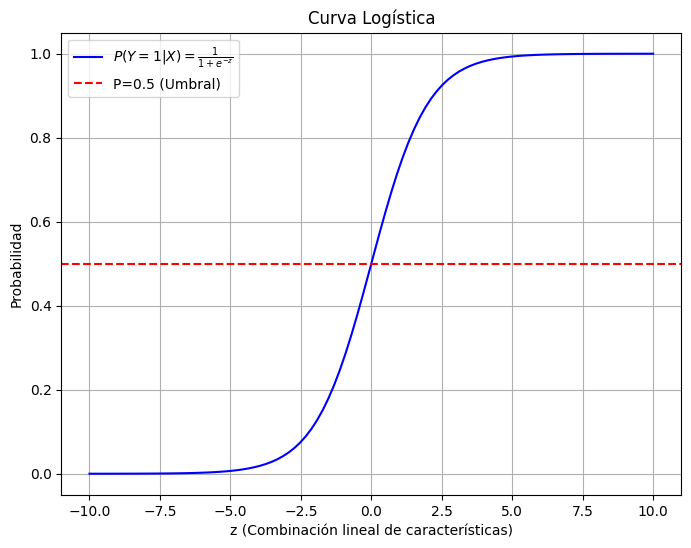

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Valores de entrada (z)
z = np.linspace(-10, 10, 100)

# Función logística
sigmoid = 1 / (1 + np.exp(-z))

# Gráfico de la curva logística
plt.figure(figsize=(8, 6))
plt.plot(z, sigmoid, label=r'$P(Y=1|X) = \frac{1}{1 + e^{-z}}$', color='blue')
plt.axhline(0.5, color='red', linestyle='--', label='P=0.5 (Umbral)')
plt.title('Curva Logística')
plt.xlabel('z (Combinación lineal de características)')
plt.ylabel('Probabilidad')
plt.grid()
plt.legend()
plt.show()


Aquí tienes la representación de la **curva logística**. La gráfica muestra cómo la probabilidad estimada por el modelo se ajusta en función de los valores de $ z $. Esta curva es el corazón de la regresión logística, permitiendo transformar una combinación lineal de variables en una probabilidad que se utiliza para la clasificación binaria.


---

### **1. Configurar PostgreSQL en Google Colab**

In [1]:
%%capture
# Instalar PostgreSQL en Google Colab
!apt update
!apt install -y postgresql postgresql-contrib

In [2]:
# Iniciar el servicio PostgreSQL
!service postgresql start

# Crear usuario y base de datos
!sudo -u postgres psql -c "CREATE USER colab_user WITH PASSWORD 'password';"
!sudo -u postgres psql -c "CREATE DATABASE colab_db;"
!sudo -u postgres psql -c "GRANT ALL PRIVILEGES ON DATABASE colab_db TO colab_user;"

 * Starting PostgreSQL 14 database server
   ...done.
CREATE ROLE
CREATE DATABASE
GRANT


---

### **2. Entrenar el Modelo en Python**

El dataset GermanCreditData incluye diferentes características, y seleccionaremos las que son más relevantes para el análisis. Vamos a usar un subconjunto de variables para evitar la redundancia y asegurarnos de que sean numéricas o correctamente codificadas:

In [3]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import fetch_openml

# Cargar el dataset German Credit Risk
data = fetch_openml('GermanCreditData', version=1, as_frame=True)
df = data.frame
y = (data.target == 2).astype(int)  # Convertir a 2 (Bad) y 1 (Good)

df.head()

,Unnamed: 0,acc_status,acc_duration,credit_history,purpose,credit_amount,savings_acc,employment_time,installment_rate,gender,...,property,age,installment_plans,housing,num_credits_at_bank,job,num_people_maintenance,phone,foreigner,target
0,600,dm_0_to_200,7,credit_paid_so_far,radio_or_tv,2329,dm_less_100,less_one,1,female,...,real_estate,45,none,own,1,skilled_employee_or_official,1,no,yes,1
1,80,no_acc,24,credit_paid_so_far,radio_or_tv,5943,unknown_or_no_savings,less_one,1,female,...,car_or_other,44,none,own,2,skilled_employee_or_official,1,yes,yes,2
2,158,dm_0_to_200,24,credit_paid_so_far,car_new,3512,dm_100_to_500,four_to_seven,2,male,...,car_or_other,38,bank,own,2,skilled_employee_or_official,1,yes,yes,1
3,423,no_acc,21,delay_in_past_credit_payment,furniture_or_equipment,1591,dm_100_to_500,four_to_seven,4,male,...,real_estate,34,none,own,2,self_or_highly_qualified_employee,1,no,yes,1
4,747,dm_less_than_0,12,credit_paid_so_far,car_new,1274,dm_less_100,less_one,3,female,...,real_estate,37,none,own,1,unskilled_resident,1,no,yes,2


In [4]:
y.value_counts()

,count
target,
0,700
1,300


In [5]:
df.housing.value_counts()

,count
housing,
own,713
rent,179
for_free,108


In [6]:
# Seleccionar variables relevantes y codificar variables categóricas
X = pd.get_dummies(df[['acc_duration', 'credit_amount', 'age', 'housing']], drop_first=True)
X.head()

,acc_duration,credit_amount,age,housing_own,housing_rent
0,7,2329,45,True,False
1,24,5943,44,True,False
2,24,3512,38,True,False
3,21,1591,34,True,False
4,12,1274,37,True,False


In [7]:
# Entrenar el modelo de regresión logística
model = LogisticRegression(max_iter=2000, random_state=42).fit(X, y)

# Obtener coeficientes y constante
coefficients = model.coef_[0]
intercept = model.intercept_[0]

print("Coeficientes:", coefficients)
print("Intercepto:", intercept)

# Asignar coeficientes a variables específicas
coef_duration = coefficients[0]
coef_amount = coefficients[1]
coef_age = coefficients[2]
coef_housing_owned = coefficients[3]

Coeficientes: [ 3.36497943e-02  1.92540979e-05 -1.85319685e-02 -5.40539409e-01
  2.87007840e-02]
Intercepto: -0.6318592395276161


En este caso:

- `acc_duration`, `credit_amount`, y `age` son variables numéricas seleccionadas directamente.
- `housing` se convierte en una variable *dummy*, codificando own como 1 y otras categorías como 0.

---

### **3. Crear el Procedimiento Almacenado en PostgreSQL**

In [8]:
import psycopg2

# Conectar a la base de datos PostgreSQL
conn = psycopg2.connect(
    dbname="colab_db",
    user="colab_user",
    password="password",
    host="localhost"
)
cur = conn.cursor()

# Crear el procedimiento almacenado con los coeficientes entrenados
cur.execute(f"""
CREATE OR REPLACE FUNCTION logistic_classifier(features DOUBLE PRECISION[])
RETURNS TABLE(probability DOUBLE PRECISION, prediction INT)
LANGUAGE plpgsql
AS $$
DECLARE
	  coef_duration DOUBLE PRECISION := {coef_duration};
    coef_amount DOUBLE PRECISION := {coef_amount};
    coef_age DOUBLE PRECISION := {coef_age};
    coef_housing_owned DOUBLE PRECISION := {coef_housing_owned};
    intercept DOUBLE PRECISION := {intercept};
    prob DOUBLE PRECISION;
    prediction INT;
BEGIN
    -- Calcular la probabilidad usando la regresión logística
    prob := 1 / (1 + EXP(-(coef_duration * features[1] +
                           coef_amount * features[2] +
                           coef_age * features[3] +
                           coef_housing_owned * features[4] +
                           intercept)));

    -- Asignar predicción binaria
    IF prob >= 0.5 THEN
        prediction := 1;
    ELSE
        prediction := 0;
    END IF;

    -- Devolver resultados como un conjunto
    RETURN QUERY SELECT prob, prediction;
END;
$$;
""")
conn.commit()
cur.close()
conn.close()

---

### **4. Invocar el Procedimiento desde Python**

In [9]:
import psycopg2

# Conectar a la base de datos PostgreSQL
conn = psycopg2.connect(
    dbname="colab_db",
    user="colab_user",
    password="password",
    host="localhost"
)
cur = conn.cursor()

# Ejecutar la función almacenada
features = [12.0, 200.0, 35.0, 1.0]  # Ejemplo de datos de entrada
cur.execute("SELECT * FROM logistic_classifier(%s)", (features,))

# Leer el resultado como ResultSet
result = cur.fetchall()

# Mostrar resultados
for row in result:
    print(f"Probabilidad: {row[0]}, Predicción: {row[1]}")

# Cerrar conexión
cur.close()
conn.close()


Probabilidad: 0.1957031900004718, Predicción: 0


## Notas:

1. **Diferencia entre PROCEDURE y FUNCTION**: Un procedimiento (`PROCEDURE`) no puede devolver datos directamente, mientras que una función (`FUNCTION`) puede devolver valores o un conjunto de filas.
2. **Formato del resultado**: La función usa `RETURNS TABLE` para especificar las columnas devueltas.
3. **Pasar parámetros desde Python**: Los parámetros se pasan como una lista o tupla al ejecutar la función en PostgreSQL.
4. **Extensibilidad:**: Puedes modificar el procedimiento para admitir más características o cambiar el umbral de clasificación.

Con estos pasos, puedes entrenar un modelo de regresión logística en Python, implementar su lógica en PostgreSQL como un procedimiento almacenado y ejecutar predicciones desde Colab.